In [2]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.fftpack import dct, idct
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq
import glob
import os
import subprocess
from random import sample

SAMPLE_RATE = 24000
WAVELET_NAME = "mexh"
WAVELET_SCALES = np.arange(0.5, 32, 0.5)
EXAMPLES_PER_BATCH = 32
SAMPLES_PER_EXAMPLE = SAMPLE_RATE * 4
NUM_WAVES = 3
NUM_OTHER_FEATURES = 11
NUM_MELS = 32
NUM_DCT_COEFFICIENTS = 10
SYNTHESIZER_PATH = "C:\\Users\\abdulg\\source\\repos\\Synth\\out\\build\\x64-debug\\synth.exe"

PARAMETER_LBS = np.asarray([0, 0, 0, 440, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0])
PARAMETER_RANGE = np.asarray([1, 1, 1, 1661.22, 1661.22, 1, 1, 1, 1, 1, 8, 1/2, 8, 1/32]) - PARAMETER_LBS

In [ ]:
#populate validation set
datapath = os.path.abspath("./validationdata")
subprocess.run(f"{SYNTHESIZER_PATH} 600 {datapath}", stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [ ]:
#finding scale range
pywt.frequency2scale(WAVELET_NAME, SAMPLE_RATE // 2) * SAMPLE_RATE

In [ ]:
#finding biggest scale
bins = np.linspace(0, SAMPLE_RATE/2, 100)
hist = np.zeros(100 - 1)
freqs = np.fft.fftfreq(SAMPLES_PER_EXAMPLE, d=1/SAMPLE_RATE)

waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in glob.glob(os.path.join(datapath, "*.wav"))]

for wave in waves:
	result = np.abs(np.fft.fft(wave))
	hist += np.histogram(freqs, bins=bins, weights=result)[0]

hist /= len(waveFiles)

# Plot the energy content histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=bins[1] - bins[0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy')
plt.show()

In [ ]:
#show a scaleogram
import pywt
import librosa
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_RATE = 24000
WAVELET_NAME = "mexh"
WAVELET_SCALES = np.arange(0.5, 32, 1)
signal, _ = librosa.load("C:\\Users\\abdulg\\Desktop\\waves\\string.wav", sr = SAMPLE_RATE)
coeffs, _ = pywt.cwt(signal, WAVELET_SCALES, WAVELET_NAME)
plt.specgram(signal, cmap="magma")
plt.axis("off")
plt.show()

In [ ]:
[psi, x] = pywt.ContinuousWavelet("mexh").wavefun()
cosSamples = np.cos()
plt.plot(x, psi)
plt.axis("off")
plt.show()

In [ ]:
#fft plotting code
component1 = np.sin(10 * np.linspace(0,1,num=SAMPLE_RATE) )
component2 = 0.3 * np.sin(32 * np.linspace(0,1,num=SAMPLE_RATE))

signal = component1 + component2
spectrum = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/SAMPLE_RATE)

plt.plot(frequencies[:40], np.abs(spectrum)[:40])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

#plt.plot(signal)

plt.show()

In [ ]:
import pickle
with open("./lastHistory", "rb") as histFile:
	history = pickle.load(histFile)
	plt.plot(history["loss"])
	plt.plot(history["val_loss"])
	plt.title("model loss")
	plt.ylabel("loss")
	plt.xlabel("epoch")
	plt.legend(["train", "val"], loc="upper left")
	plt.show()

In [ ]:
#dct coefficient magnitudes
def normaliseParams(params):
	return (params - PARAMETER_LBS)/PARAMETER_RANGE

def processWavs(datapath):
	waveFiles = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	scaleograms = [pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0] for wave in waves]

	return (
		np.asarray([dct(scaleo, type=2, axis=1)[:, :NUM_DCT_COEFFICIENTS] for scaleo in scaleograms])
	)

def getValidationSet():
	print("generating validation data")
	datapath = os.path.abspath("./validationdata")
	subprocess.run(f"{SYNTHESIZER_PATH} 600 {datapath}", stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
	return processWavs(datapath)

def superImpose(heights):
	#colors = [np.random.choice(range(256), size=3) for _ in range(len(heights))]
	canvases = [np.zeros((len(heights), max(heights))) for _ in range(len(heights))]
	for i in range(heights):
		for h in heights:
			canvases[i][:h] = 1
	return np.transpose(np.mean(canvases, axis=1))


#energy
arrs = getValidationSet()
indices = np.arange((arrs[0].shape)[-1])

for arr in arrs:
    plt.bar(indices, np.sum(np.square(arr), axis=0), alpha=0.3) 

plt.xlabel("Index")
plt.ylabel("Value")

plt.show()

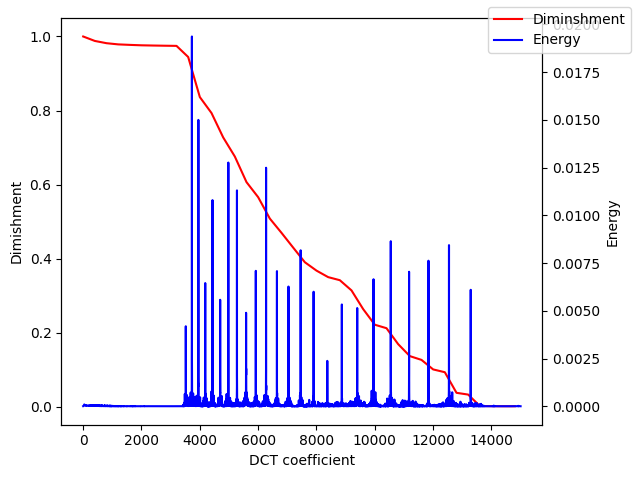

In [11]:
#check energy retention for some number of DCT coefficients
def loadScaleos():
	datapath = os.path.abspath("./validationdata")
	waveFiles = glob.glob(os.path.join(datapath, "*.wav"))
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	wavesWithEnergy = [w for w in waves if np.max(w) > 0]
	return np.asarray([pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0] for wave in wavesWithEnergy])

def invertDCT(scaleo):
	return idct(scaleo, type=2, axis=1, norm="ortho")

scaleos = loadScaleos()
dcts = np.asarray([dct(scaleo, type=2, axis=1, norm="ortho") for scaleo in scaleos])

def getAverageEnergyDiminishment(numCoeffs):
	truncDCTs = dcts[:, :, :numCoeffs]
	rehydratedScaleos = np.asarray([invertDCT(truncScaleo) for truncScaleo in truncDCTs])
	rehydratedEnergies = np.asarray([np.sum(rehydratedScaleo ** 2) for rehydratedScaleo in rehydratedScaleos])
	return np.mean(1 - rehydratedEnergies / scaleoEnergies)

energiesPerCoefficientPerExample = np.sum(dcts ** 2, axis=1)
scaleoEnergies = np.sum(energiesPerCoefficientPerExample, axis=1)

candidates = range(1, 15000, 400)
diminishment = [getAverageEnergyDiminishment(c) for c in candidates]

meanNormalisedEPCPE = np.mean(energiesPerCoefficientPerExample / scaleoEnergies[:, np.newaxis], axis=0)

fig, ax1 = plt.subplots()

ax1.set_xlabel("DCT coefficient")
ax1.set_ylabel("Dimishment")
ax1.plot(candidates, diminishment, color="red", label="Diminshment")

ax2 = ax1.twinx()

ax2.set_ylabel("Energy")
ax2.plot(meanNormalisedEPCPE[:15000], color="blue", label="Energy")
fig.legend(loc="upper right")
fig.tight_layout()

plt.show()

In [ ]:
#exponential downsampling
BASE = 1.01
PREFIX = 500
signal, _ = librosa.load("C:\\Users\\abdulg\\source\\repos\\Synth\\backwards\\validationdata\\137.wav", sr = SAMPLE_RATE)
coeffs = np.abs(pywt.cwt(signal[PREFIX:], WAVELET_SCALES, WAVELET_NAME)[0])

STOPPING_POINT = 0
for i in range(1, SAMPLES_PER_EXAMPLE):
	if i + BASE ** i >= SAMPLES_PER_EXAMPLE - PREFIX:
		STOPPING_POINT = i - 1
		break

def logScaleImage(image):
	indices = [i + int(BASE ** i) for i in range(1, STOPPING_POINT)]
	splitImage = np.split(image, indices, axis=1) #inhomogeneous :(
	return np.asarray([
		[np.mean(frame) for frame in imageFrame] for imageFrame in splitImage
	]).T

fig, ax = plt.subplots(2)
ax[0].imshow(coeffs, aspect="auto")
ax[1].imshow(logScaleImage(coeffs), aspect="auto")
plt.tight_layout()
plt.show()

In [ ]:
#saw wave fft
from scipy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation, FFMpegWriter

fig, ax = plt.subplots()
sawwave = np.mod(np.arange(0, 3, 0.001), 1) - 0.5
sawFFT = rfft(sawwave)

def getFrame(num):
	sawFFTTrunc = sawFFT.copy()
	sawFFTTrunc[num:] = 0
	ax.clear()
	ax.set_title(f"Number of coefficients: {num}")
	ax.set_xlabel("Sample")
	ax.set_ylabel("Amplitude")
	ax.set_ylim([-0.7, 0.7])
	ax.plot(sawwave)
	ax.plot(irfft(sawFFTTrunc))
	return []

ani = FuncAnimation(fig, getFrame, frames=[3, 10, 25, 100, 500, 750, 1000, 1250, 1445, 1500])
mywriter = FFMpegWriter(fps=1)
ani.save("saw.gif",writer=mywriter)


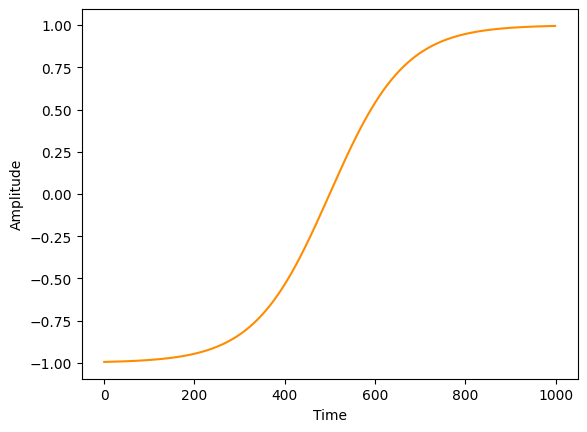

In [8]:
N = 1000
signal = np.tanh(np.linspace(-3, 3, N))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(range(len(signal)), signal, color="darkorange")

c:\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


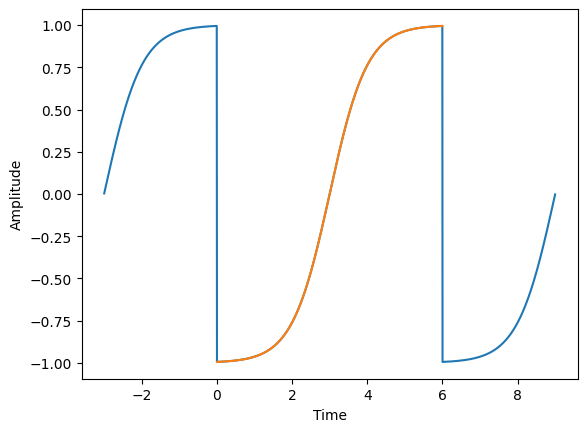

In [4]:
tanhFFT = fft(signal)
plt.plot(
	np.linspace(-3, 9, 2 * N),
	[
		np.sum(
			[(1/N) * tanhFFT[freq] * np.exp(1j * index * freq * 2 * np.pi / N)
			for freq in range(len(tanhFFT))]
		)
		for index in range(int(-N/2), int(3 * N/2))
	]
)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(np.linspace(0, 6, N) , signal)
plt.show()

In [ ]:
signalMirrored = np.concatenate([np.flip(signal)[:-1], signal])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(np.linspace(-6, 6, 2 * N - 1), signalMirrored)
plt.show()

In [ ]:
tanhFFT = fft(signalMirrored)
N = len(tanhFFT) 
plt.plot(
	np.linspace(-12, 12, 4000),
	[
		np.sum(
			[0.0005 * tanhFFT[freq] * np.exp(1j * index * freq * 2 * np.pi / N)
			for freq in range(len(tanhFFT))]
		)
		for index in range(-1000, 3000)
	]
)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(np.linspace(-6, 6, 2000) , signalMirrored)
plt.show()

In [ ]:
spectrum = np.abs(np.fft.rfft(signal))
spectrumMirrored = np.abs(np.fft.rfft(signalMirrored))

freqs = np.fft.rfftfreq(len(signal))
freqsMirrored = np.fft.rfftfreq(len(signalMirrored))

plt.plot(freqs, spectrum / np.sum(spectrum), label="DFT")
plt.plot(freqsMirrored, spectrumMirrored / np.sum(spectrumMirrored), label="Mirrored DFT")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.xlim(0,0.02)
plt.legend()
plt.show()

In [ ]:
96000  